In [1]:
###### PARAM FOR LAST GOOD DATE BELOW TO BE SET ######
###### PARAM FOR LAST COMPLETE MONTH DOWNSTREAM TO BET MANUALLY SET! ####
###### PARAM for linreg start_year to be set #####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

sns.set()

#param
#linreg_start_year = 1861
linreg_start_year = 2010
linreq_age_adj_start_year = 2010


In [2]:
#### the pymc models are weird - most times the don't sample first time ####


In [3]:
##### excess calculation example #####

df_foo = pd.DataFrame({'pop' : [1000,10000],'dead' : [10,100]},index=['Y1','Y2'])
excess_foo = df_foo.loc['Y2','dead'] - df_foo.loc['Y1','dead']
df_foo['mortality'] = df_foo['dead'] / df_foo['pop']
diff_mortality = df_foo.loc['Y2','mortality'] - df_foo.loc['Y1','mortality']
print (df_foo)
print ('abs_exess',excess_foo)
print ('diff mortality',diff_mortality)
print ('scaled excess', diff_mortality * df_foo.loc['Y2','pop'])


      pop  dead  mortality
Y1   1000    10       0.01
Y2  10000   100       0.01
abs_exess 90
diff mortality 0.0
scaled excess 0.0


In [4]:
def parse_scb_prel(YTD=True):
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
    
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    
    df = df.replace(np.nan,0)

    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    #if YTD:
        #df = df.loc[df['2020'] != 0]
        
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    if YTD:
        index = pd.date_range('2020-01-01',periods=len(all_deaths))
    else:
        index = pd.date_range('2020-01-01','2020-12-31')
        
    
        
    all_deaths.index = index
    
    if YTD:
        all_deaths = all_deaths.loc[all_deaths['2020'] != 0]
    
    return all_deaths
    
    

In [5]:
def parse_scb_prel_2021(YTD=True):
    
    df = pd.read_csv('scb-dead_per_day.csv',sep=';',thousands=',',header=0,usecols=[1,2,3,4,5,6,7,8,9])
    unknown_date = df.loc[366]
    df = df.loc[:365]
    
    daily_ratio = df / df.sum()
    
    df = df + daily_ratio * unknown_date
    df.index = pd.date_range('2020-01-01','2020-12-31')
    return df

In [6]:
df = parse_scb_prel_2021()



In [7]:
df.sum()

2015         90907.0
2016         90982.0
2017         91972.0
2018         92185.0
2019         88766.0
2020         97164.0
2021           552.0
2015-2019    91161.0
2016-2020    92364.0
dtype: float64

In [8]:
df['2015-2018_avg'] = df.loc[:,'2015' : '2018'].mean(axis=1)

In [9]:
#### PARAM ##### 
last_good_date = '2020-12-31'
df = df.loc[:last_good_date].copy()
df

,2015,2016,2017,2018,2019,2020,2021,2015-2019,2016-2020,2015-2018_avg
2020-01-01,298.148521,250.402611,347.423815,282.706698,309.109692,260.936721,96.574586,297.714505,290.488337,294.670411
2020-01-02,274.903043,277.998000,324.877137,320.743599,284.380917,310.247597,113.856354,296.691431,303.832324,299.630445
2020-01-03,283.999099,299.461081,317.703194,303.267185,279.229089,262.991341,109.790055,296.691431,292.541258,301.107640
2020-01-04,258.732276,265.733383,312.578949,292.986941,290.563111,281.482919,80.309392,284.414545,288.435416,282.507887
2020-01-05,270.860351,265.733383,311.554100,299.155087,283.350551,272.237130,58.961326,286.460692,286.382494,286.825730
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,229.422760,254.490817,277.734082,246.725845,245.227023,315.384147,0.000000,250.653106,267.906205,252.093376
2020-12-28,276.924389,267.777486,279.783780,268.314357,221.528613,323.602626,0.000000,262.929993,272.012047,273.200003
2020-12-29,295.116502,280.042103,282.858327,270.370405,251.409216,223.953564,0.000000,276.229953,261.747441,282.096834
2020-12-30,286.020445,313.769802,281.833478,238.501650,232.862635,141.768770,0.000000,271.114584,242.244691,280.031344


In [10]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2021               552.0
2015-2019        91161.0
2016-2020        92364.0
2015-2018_avg    91511.5
dtype: float64

In [11]:
df['excess'] = df['2020'] - df['2015-2018_avg']
df.drop(['2021','2016-2020','2015-2019'],axis=1,inplace=True)
df

,2015,2016,2017,2018,2019,2020,2015-2018_avg,excess
2020-01-01,298.148521,250.402611,347.423815,282.706698,309.109692,260.936721,294.670411,-33.733690
2020-01-02,274.903043,277.998000,324.877137,320.743599,284.380917,310.247597,299.630445,10.617153
2020-01-03,283.999099,299.461081,317.703194,303.267185,279.229089,262.991341,301.107640,-38.116299
2020-01-04,258.732276,265.733383,312.578949,292.986941,290.563111,281.482919,282.507887,-1.024968
2020-01-05,270.860351,265.733383,311.554100,299.155087,283.350551,272.237130,286.825730,-14.588600
...,...,...,...,...,...,...,...,...
2020-12-27,229.422760,254.490817,277.734082,246.725845,245.227023,315.384147,252.093376,63.290771
2020-12-28,276.924389,267.777486,279.783780,268.314357,221.528613,323.602626,273.200003,50.402623
2020-12-29,295.116502,280.042103,282.858327,270.370405,251.409216,223.953564,282.096834,-58.143271
2020-12-30,286.020445,313.769802,281.833478,238.501650,232.862635,141.768770,280.031344,-138.262574


In [12]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [13]:
pop = pd.read_pickle('pop_2015_2020.pkl')
pop.loc['excess'] = pop.loc['2020']
pop.loc['2015-2018_avg'] = pop.loc['2015' : '2018'].mean()

### setting the baseline pop to 2020 yields correct erroneous excess !!! #
#pop.loc['2015-2018_avg'] = pop.loc['2020']
###

pop

year
2015              9838418.0
2016              9967637.0
2017             10104036.0
2018             10215309.0
2019             10319473.0
2020             10378483.0
excess           10378483.0
2015-2018_avg    10031350.0
Name: pop, dtype: float64

In [14]:
## for excess to be correct, the diff must be obtained from dividing the abs diff with the pop ! ##
df_per_m = df / (pop / 1e6 )

# taking the diff after having made fractions yields wrong result! b/c populations are different!

# that is: df_per_m['excess'] which gives correct result is divided by population 2020, 
# while df_per_m['wrong_excess'] is calculated by diff 2020 - baseline, where the deaths are 
# already divided by population 2015-2018_avg, a smaller population which results in larger abs numbers. 

### BOTTOM LINE : dont add/subtract fractions where the denominator is different! ###

df_per_m['wrong_excess'] = df_per_m['2020'] - df_per_m['2015-2018_avg']

df_per_m

,2015,2015-2018_avg,2016,2017,2018,2019,2020,excess,wrong_excess
2020-01-01,30.304519,29.374951,25.121562,34.384657,27.674806,29.954019,25.142087,-3.250349,-4.232864
2020-01-02,27.941793,29.869404,27.890061,32.153205,31.398326,27.557698,29.893347,1.022997,0.023943
2020-01-03,28.866338,30.016662,30.043337,31.443197,29.687519,27.058464,25.340056,-3.672627,-4.676606
2020-01-04,26.298158,28.162499,26.659617,30.936049,28.681163,28.156778,27.121779,-0.098759,-1.040721
2020-01-05,27.530885,28.592934,26.659617,30.834619,29.284977,27.457851,26.230917,-1.405658,-2.362017
...,...,...,...,...,...,...,...,...,...
2020-12-27,23.319070,25.130553,25.531710,27.487440,24.152558,23.763522,30.388270,6.098268,5.257717
2020-12-28,28.147248,27.234620,26.864691,27.690299,26.265907,21.467047,31.180147,4.856454,3.945527
2020-12-29,29.996337,28.121522,28.095135,27.994588,26.467178,24.362602,21.578641,-5.602290,-6.542881
2020-12-30,29.071792,27.915619,31.478855,27.893159,23.347473,22.565361,13.659874,-13.322041,-14.255745


In [15]:
# if you subtract fractions youll get wrong result! #
per_m_diff = df_per_m['2020'] - df_per_m['2015-2018_avg']
per_m_diff.sum()

239.51107035794325

In [16]:
df_per_m.sum()

2015             9240.001797
2015-2018_avg    9122.550803
2016             9127.740105
2017             9102.501218
2018             9024.200834
2019             8601.795848
2020             9362.061874
excess            544.636437
wrong_excess      239.511070
dtype: float64

<AxesSubplot:>

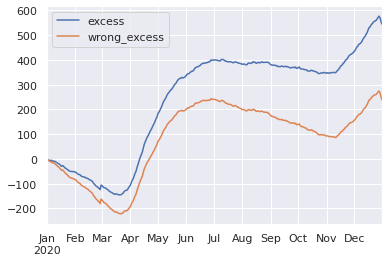

In [17]:
df_per_m.cumsum().plot(y=['excess','wrong_excess'])

<AxesSubplot:>

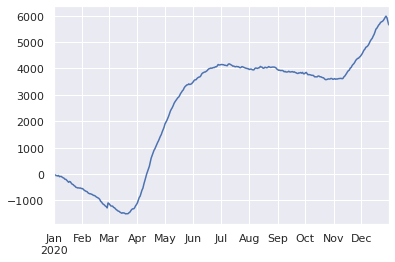

In [18]:
df['excess'].cumsum().plot()

In [19]:
df.sum() / pop

2015             0.009240
2015-2018_avg    0.009123
2016             0.009128
2017             0.009103
2018             0.009024
2019             0.008602
2020             0.009362
excess           0.000545
dtype: float64

In [20]:
(df['excess'] / (pop.loc['2020'] / 1e6)).cumsum()

2020-01-01     -3.250349
2020-01-02     -2.227352
2020-01-03     -5.899979
2020-01-04     -5.998738
2020-01-05     -7.404397
                 ...    
2020-12-27    571.618018
2020-12-28    576.474472
2020-12-29    570.872182
2020-12-30    557.550141
2020-12-31    544.636437
Freq: D, Name: excess, Length: 366, dtype: float64

In [21]:
df.sum().loc['2020'] - df.sum().loc['2015-2018_avg']

5652.499999999913

In [22]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [23]:
pop_diff = pop.loc['2020'] - pop.loc['2015-2018_avg']
pop_diff

347133.0

In [24]:
dead_diff = df.sum().loc['2020'] - df.sum().loc['2015-2018_avg']
dead_diff

5652.499999999913

In [25]:
dead_diff / (pop.loc['2020'] / 1e6)

544.6364367509118

In [26]:
df_per_m.sum()

2015             9240.001797
2015-2018_avg    9122.550803
2016             9127.740105
2017             9102.501218
2018             9024.200834
2019             8601.795848
2020             9362.061874
excess            544.636437
wrong_excess      239.511070
dtype: float64

In [27]:
dead_per_m_2020 = df_per_m.sum().loc['2020']
dead_per_m_15_18 = df_per_m.sum().loc['2015-2018_avg']

print (dead_per_m_15_18)
print (dead_per_m_2020)

9122.550803231865
9362.061873589817


In [28]:
# diff in cum mortality expressed in millions
dead_per_m_2020 - dead_per_m_15_18

239.51107035795212

In [29]:
# diff in mortality
mort_diff = ((df.sum() / pop).loc['2020'] - (df.sum() / pop).loc['2015-2018_avg']) 
mort_diff

0.0002395110703579343

In [30]:
mortality = df_per_m.sum() / 1e6
mortality


2015             0.009240
2015-2018_avg    0.009123
2016             0.009128
2017             0.009103
2018             0.009024
2019             0.008602
2020             0.009362
excess           0.000545
wrong_excess     0.000240
dtype: float64

In [31]:
dead_2020 = mortality.loc['2020'] * pop.loc['2020']
dead_15_18 = mortality.loc['2015-2018_avg'] * pop.loc['2015-2018_avg']

print (dead_2020)
print (dead_15_18)

print (dead_2020 - dead_15_18)

97164.00000000006
91511.49999999997
5652.500000000087


In [32]:
pop

year
2015              9838418.0
2016              9967637.0
2017             10104036.0
2018             10215309.0
2019             10319473.0
2020             10378483.0
excess           10378483.0
2015-2018_avg    10031350.0
Name: pop, dtype: float64

In [33]:
abs_totals = df.sum()
abs_totals

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [34]:
mortality = abs_totals / pop
mortality

2015             0.009240
2015-2018_avg    0.009123
2016             0.009128
2017             0.009103
2018             0.009024
2019             0.008602
2020             0.009362
excess           0.000545
dtype: float64

In [35]:
mortality.loc['excess']

0.00054463643675092

In [36]:
mort_diff * pop.loc['2020']

2485.761572021625

In [37]:
calc_deaths = mortality * pop
calc_deaths

2015             90907.0
2015-2018_avg    91511.5
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
excess            5652.5
dtype: float64

In [38]:
calc_diff = calc_deaths.loc['2020'] - calc_deaths.loc['2015-2018_avg']
calc_diff

5652.499999999913

In [39]:
mortality

2015             0.009240
2015-2018_avg    0.009123
2016             0.009128
2017             0.009103
2018             0.009024
2019             0.008602
2020             0.009362
excess           0.000545
dtype: float64

In [40]:
pop_adj_deaths = mortality * pop.loc['2020']

pop_adj_deaths.index = pd.Categorical(pop_adj_deaths.index,
                                      ['2015','2016','2017','2018','2019','2015-2018_avg','2020','excess'])

pop_adj_deaths.sort_index(inplace=True)
pop_adj_deaths

2015             95897.201571
2016             94732.095511
2017             94470.154152
2018             93657.514947
2019             89273.591973
2015-2018_avg    94678.238428
2020             97164.000000
excess            5652.500000
dtype: float64

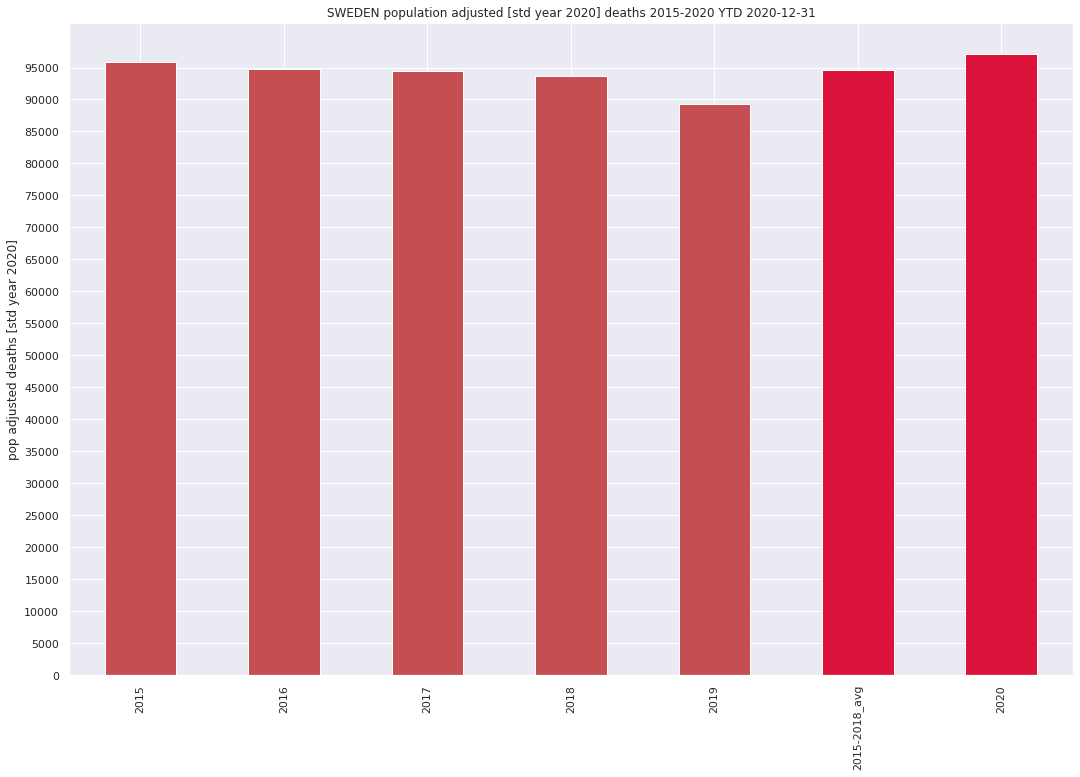

In [41]:
colors = ['r'] * 5
colors.extend(['crimson','crimson'])


title = 'SWEDEN population adjusted [std year 2020] deaths 2015-2020 YTD {}'.format(df_per_m.index[-1].date())
pop_adj_deaths[:-1].plot(kind='bar',figsize=(18,12),title=title,color=colors)
_= plt.yticks(np.arange(0,100000,5000))
plt.ylabel('pop adjusted deaths [std year 2020]')
plt.savefig('swe_pop_adj_deaths_ytd_15_20.jpg',format='jpg')


In [42]:
df.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [43]:
from pandas.tseries.offsets import MonthEnd
month_ends = df_per_m.index + MonthEnd(0)
month_ends

DatetimeIndex(['2020-01-31', '2020-01-31', '2020-01-31', '2020-01-31',
               '2020-01-31', '2020-01-31', '2020-01-31', '2020-01-31',
               '2020-01-31', '2020-01-31',
               ...
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31', '2020-12-31', '2020-12-31',
               '2020-12-31', '2020-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

In [44]:
#### historical monthly deaths

url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/ManadFoddDod'

data = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Manad",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12",
          "90"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000000NF"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [45]:
r = requests.post(url,json=data)

In [46]:
r.status_code

200

In [47]:
json = r.json()
json['data'][0]

{'key': ['1', '01', '1851'], 'values': ['3245']}

In [48]:
data_list = []

nr_records = (len(json['data']))

for rec in range(nr_records):

    data_list.append ((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['key'][2],
                        json['data'][rec]['values'][0]))



In [49]:
hist_deaths = pd.DataFrame(data_list,columns=['gender','month','year','deaths'])
hist_deaths['deaths'] = hist_deaths['deaths'].astype(int)
hist_deaths.head()

,gender,month,year,deaths
0,1,01,1851,3245
1,1,01,1852,3403
2,1,01,1853,3559
3,1,01,1854,2980
4,1,01,1855,3244


In [50]:
hist_deaths = hist_deaths.groupby(['year','month']).sum()
hist_deaths

deaths
year month        
1851 01       6261
     02       6007
     03       8812
     04       7818
     05       7406
...            ...
2020 09       6772
     10       7281
     11       8220
     12      10187
     90        254

[2210 rows x 1 columns]

In [51]:
yearly_sums = hist_deaths.groupby('year').sum()
yearly_sums

,deaths
year,
1851,72506
1852,80090
1853,84047
1854,70846
1855,77734
...,...
2016,90982
2017,91972
2018,92185


In [52]:
unknown_month_mask = hist_deaths.index.get_level_values('month') == '90'
unknown_month_mask

array([False, False, False, ..., False, False,  True])

In [53]:
unknown_death_months = hist_deaths.loc[unknown_month_mask]['deaths']
unknown_death_months = unknown_death_months.reset_index().set_index('year')
unknown_death_months

,month,deaths
year,,
1851,90,0
1852,90,0
1853,90,0
1854,90,0
1855,90,0
...,...,...
2016,90,186
2017,90,197
2018,90,248


In [54]:
hist_deaths = (hist_deaths.loc[~unknown_month_mask]).copy()
hist_deaths

deaths
year month        
1851 01       6261
     02       6007
     03       8812
     04       7818
     05       7406
...            ...
2020 08       6968
     09       6772
     10       7281
     11       8220
     12      10187

[2040 rows x 1 columns]

In [55]:
# wow! 
hist_deaths['ratio_of_year'] = hist_deaths / hist_deaths.groupby('year').sum()
hist_deaths

deaths  ratio_of_year
year month                       
1851 01       6261       0.086351
     02       6007       0.082848
     03       8812       0.121535
     04       7818       0.107826
     05       7406       0.102143
...            ...            ...
2020 08       6968       0.071196
     09       6772       0.069194
     10       7281       0.074395
     11       8220       0.083989
     12      10187       0.104087

[2040 rows x 2 columns]

In [56]:
hist_deaths.groupby('year').sum()

,deaths,ratio_of_year
year,,
1851,72506,1.0
1852,80090,1.0
1853,84047,1.0
1854,70846,1.0
1855,77734,1.0
...,...,...
2016,90796,1.0
2017,91775,1.0
2018,91937,1.0


In [57]:
hist_deaths


deaths  ratio_of_year
year month                       
1851 01       6261       0.086351
     02       6007       0.082848
     03       8812       0.121535
     04       7818       0.107826
     05       7406       0.102143
...            ...            ...
2020 08       6968       0.071196
     09       6772       0.069194
     10       7281       0.074395
     11       8220       0.083989
     12      10187       0.104087

[2040 rows x 2 columns]

In [58]:
hist_deaths = hist_deaths.reset_index().set_index('year')
hist_deaths

,month,deaths,ratio_of_year
year,,,
1851,01,6261,0.086351
1851,02,6007,0.082848
1851,03,8812,0.121535
1851,04,7818,0.107826
1851,05,7406,0.102143
...,...,...,...
2020,08,6968,0.071196
2020,09,6772,0.069194
2020,10,7281,0.074395


In [59]:
hist_deaths['corr_deaths'] = unknown_death_months['deaths'] * hist_deaths['ratio_of_year'] + hist_deaths['deaths']
hist_deaths['delta'] = hist_deaths['corr_deaths'] - hist_deaths['deaths']
hist_deaths

,month,deaths,ratio_of_year,corr_deaths,delta
year,,,,,
1851,01,6261,0.086351,6261.000000,0.000000
1851,02,6007,0.082848,6007.000000,0.000000
1851,03,8812,0.121535,8812.000000,0.000000
1851,04,7818,0.107826,7818.000000,0.000000
1851,05,7406,0.102143,7406.000000,0.000000
...,...,...,...,...,...
2020,08,6968,0.071196,6986.083907,18.083907
2020,09,6772,0.069194,6789.575232,17.575232
2020,10,7281,0.074395,7299.896230,18.896230


In [60]:
hist_deaths.groupby(hist_deaths.index).sum()

,deaths,ratio_of_year,corr_deaths,delta
year,,,,
1851,72506,1.0,72506.0,0.0
1852,80090,1.0,80090.0,0.0
1853,84047,1.0,84047.0,0.0
1854,70846,1.0,70846.0,0.0
1855,77734,1.0,77734.0,0.0
...,...,...,...,...
2016,90796,1.0,90982.0,186.0
2017,91775,1.0,91972.0,197.0
2018,91937,1.0,92185.0,248.0


In [61]:
yearly_sums

,deaths
year,
1851,72506
1852,80090
1853,84047
1854,70846
1855,77734
...,...
2016,90982
2017,91972
2018,92185


In [62]:
hist_deaths

,month,deaths,ratio_of_year,corr_deaths,delta
year,,,,,
1851,01,6261,0.086351,6261.000000,0.000000
1851,02,6007,0.082848,6007.000000,0.000000
1851,03,8812,0.121535,8812.000000,0.000000
1851,04,7818,0.107826,7818.000000,0.000000
1851,05,7406,0.102143,7406.000000,0.000000
...,...,...,...,...,...
2020,08,6968,0.071196,6986.083907,18.083907
2020,09,6772,0.069194,6789.575232,17.575232
2020,10,7281,0.074395,7299.896230,18.896230


In [63]:
dates = pd.to_datetime(hist_deaths.index + '-' + hist_deaths['month'],infer_datetime_format=True)
dates

year
1851   1851-01-01
1851   1851-02-01
1851   1851-03-01
1851   1851-04-01
1851   1851-05-01
          ...    
2020   2020-08-01
2020   2020-09-01
2020   2020-10-01
2020   2020-11-01
2020   2020-12-01
Length: 2040, dtype: datetime64[ns]

In [64]:
hist_deaths.index = dates
hist_deaths

,month,deaths,ratio_of_year,corr_deaths,delta
1851-01-01,01,6261,0.086351,6261.000000,0.000000
1851-02-01,02,6007,0.082848,6007.000000,0.000000
1851-03-01,03,8812,0.121535,8812.000000,0.000000
1851-04-01,04,7818,0.107826,7818.000000,0.000000
1851-05-01,05,7406,0.102143,7406.000000,0.000000
...,...,...,...,...,...
2020-08-01,08,6968,0.071196,6986.083907,18.083907
2020-09-01,09,6772,0.069194,6789.575232,17.575232
2020-10-01,10,7281,0.074395,7299.896230,18.896230
2020-11-01,11,8220,0.083989,8241.333197,21.333197


In [65]:
hist_deaths_ytd = hist_deaths.copy()
hist_deaths_ytd = hist_deaths_ytd['corr_deaths']
hist_deaths_ytd

1851-01-01     6261.000000
1851-02-01     6007.000000
1851-03-01     8812.000000
1851-04-01     7818.000000
1851-05-01     7406.000000
                  ...     
2020-08-01     6986.083907
2020-09-01     6789.575232
2020-10-01     7299.896230
2020-11-01     8241.333197
2020-12-01    10213.438112
Name: corr_deaths, Length: 2040, dtype: float64

In [66]:
(hist_deaths_ytd[hist_deaths_ytd.index.get_level_values(0) == 2019]).sum()

0.0

In [67]:
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2015           366 non-null    float64
 1   2016           366 non-null    float64
 2   2017           366 non-null    float64
 3   2018           366 non-null    float64
 4   2019           366 non-null    float64
 5   2020           366 non-null    float64
 6   2015-2018_avg  366 non-null    float64
 7   excess         366 non-null    float64
dtypes: float64(8)
memory usage: 25.7 KB


In [68]:
df_monthly = df.resample('M').sum()
df_monthly.sum()

2015             90907.0
2016             90982.0
2017             91972.0
2018             92185.0
2019             88766.0
2020             97164.0
2015-2018_avg    91511.5
excess            5652.5
dtype: float64

In [69]:
hist_deaths_ytd = pd.concat([hist_deaths_ytd,df_monthly['2020']])
hist_deaths_ytd

1851-01-01    6261.000000
1851-02-01    6007.000000
1851-03-01    8812.000000
1851-04-01    7818.000000
1851-05-01    7406.000000
                 ...     
2020-08-31    6973.379770
2020-09-30    6766.890475
2020-10-31    7246.644210
2020-11-30    8222.588638
2020-12-31    9362.902655
Length: 2052, dtype: float64

In [70]:
hist_deaths_ytd.tail(50)

2017-11-01     7498.060518
2017-12-01     8276.728390
2018-01-01     8826.746087
2018-02-01     8359.489052
2018-03-01     9462.456302
2018-04-01     7818.032403
2018-05-01     6971.755713
2018-06-01     6680.973438
2018-07-01     7488.144925
2018-08-01     6989.804268
2018-09-01     6970.753016
2018-10-01     7460.069395
2018-11-01     7121.157641
2018-12-01     8035.617760
2019-01-01     8396.783784
2019-02-01     7509.163902
2019-03-01     7814.063839
2019-04-01     7394.826426
2019-05-01     7168.157394
2019-06-01     6653.638751
2019-07-01     6964.556449
2019-08-01     7051.813997
2019-09-01     6875.292981
2019-10-01     7558.308958
2019-11-01     7460.018847
2019-12-01     7919.374672
2020-01-01     8369.665393
2020-02-01     7560.571002
2020-03-01     8579.207806
2020-04-01    10582.393175
2020-05-01     8944.152488
2020-06-01     7459.308879
2020-07-01     7098.374579
2020-08-01     6986.083907
2020-09-01     6789.575232
2020-10-01     7299.896230
2020-11-01     8241.333197
2

<AxesSubplot:>

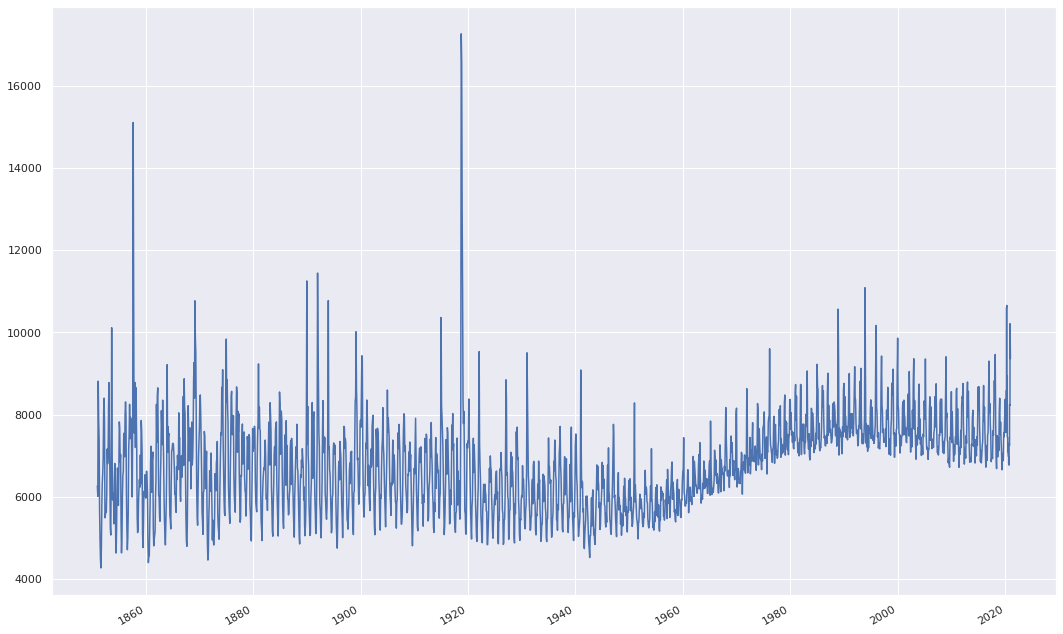

In [71]:
hist_deaths_ytd.plot(figsize=(18,12))

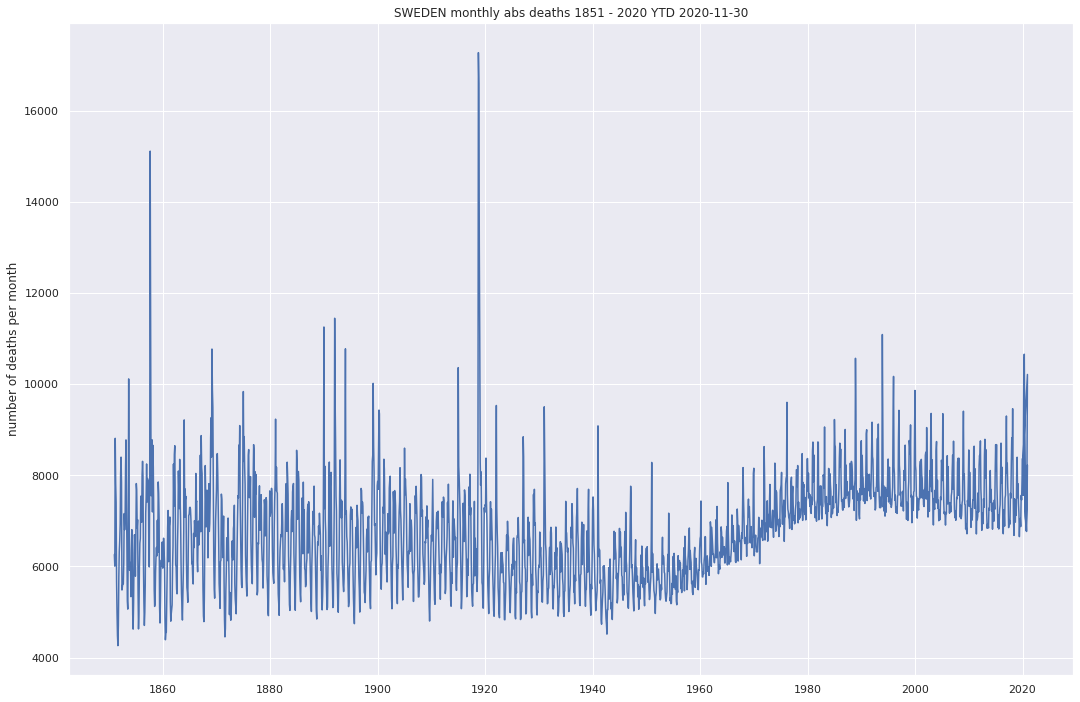

In [72]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN monthly abs deaths 1851 - 2020 YTD {}'.format(hist_deaths_ytd.index[-2].date()))
plt.plot(hist_deaths_ytd[:-1])
plt.ylabel('number of deaths per month')
plt.savefig('swe_historical_abs_deaths.jpg',format='jpg')

In [73]:
## population 1860 - 2020

pop_url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'

pop_data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [74]:
r_pop = requests.post(pop_url, json=pop_data)

In [75]:
r_pop.status_code

404

In [76]:
pop_json = r_pop.json()
pop_json['data'][0]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
pop_list = []

nr_records = (len(pop_json['data']))

for rec in range(nr_records):

    pop_list.append ((pop_json['data'][rec]['key'][0],pop_json['data'][rec]['key'][1],
                       pop_json['data'][rec]['key'][2],
                        pop_json['data'][rec]['values'][0]))



In [ ]:
l = list(range(0,100))

str_l = [str(i) for i in l]

str_l.append('100+')
str_l

In [ ]:
pop_df = pd.DataFrame(pop_list,columns=['age','gender','year','pop'])
pop_df['pop'] = pop_df['pop'].astype(int)
pop_df['age'] = pd.Categorical(pop_df['age'],str_l)


In [ ]:
pop_df = pop_df.sort_values(['year','age'])
pop_df

In [ ]:
pop_df = pop_df.groupby(['year','age']).sum()
pop_df

In [ ]:
pop_df.loc['2019'].sum()

In [ ]:
total_pops = pop_df.groupby('year').sum()
total_pops.index = pd.to_datetime(total_pops.index).year

In [ ]:
total_pops

In [ ]:
hist_deaths_ytd.resample('Y').sum()

In [ ]:
yearly_abs_deaths = hist_deaths_ytd.resample('Y').sum()

yearly_abs_deaths.index = yearly_abs_deaths.index.year

In [ ]:
yearly_abs_deaths

In [ ]:
# includes partial 2020 deaths ! #

title='SWEDEN population 1861 - 2019'
#ax = yearly_abs_deaths[:-1].plot(label='abs_deaths',style='ro--',figsize=(18,12),title=title)
#ax.legend(loc='upper left')
#ax.set_ylabel('abs deaths')
#ax = plt.gca()
#ax2 = plt.twinx()
total_pops.plot(style='bo--',figsize=(18,12),title=title)
plt.ylabel('population')
plt.xlabel('year')
plt.legend(loc='upper left')
#ax2.legend(loc='upper right')
#ax2.set_ylabel('population')

plt.savefig('awe_pop_1861_2019.jpg',format='jpg')

In [ ]:
hist_deaths_ytd

In [ ]:
total_pops.loc['2020','pop'] = np.nan
total_pops = total_pops.shift()
total_pops

In [ ]:
foo = hist_deaths_ytd.groupby([hist_deaths_ytd.index.year]).sum()
foo.index.name='year'
foo

In [ ]:
hist_deaths_ytd = pd.DataFrame(hist_deaths_ytd)
hist_deaths_ytd['year'] = hist_deaths_ytd.index.year
hist_deaths_ytd.columns=['dead','year']

In [ ]:
hist_deaths_ytd

In [ ]:
total_pops.index = pd.to_datetime(total_pops.index,format='%Y')
total_pops['y'] = total_pops.index.year
total_pops

In [ ]:
total_pops.reset_index()

In [ ]:
hist_deaths_ytd = hist_deaths_ytd.reset_index()
hist_deaths_ytd

In [ ]:
hist_deaths_ytd = hist_deaths_ytd.set_index('year')
hist_deaths_ytd

In [ ]:
total_pops = total_pops.set_index('y')
total_pops

In [ ]:
mortality_per_month = hist_deaths_ytd['dead'] / total_pops['pop']
mortality_per_month = pd.DataFrame(mortality_per_month,columns=['mortality'])
mortality_per_month

In [ ]:
mortality_per_month.index = hist_deaths_ytd['index']
mortality_per_month['month'] = mortality_per_month.index.month
mortality_per_month

In [ ]:
mortality_per_month = mortality_per_month.dropna()

In [ ]:
mortality_per_month

In [ ]:
### param ### 
last_complete_month = 12
###

full_mortality_per_month = mortality_per_month.copy()

mortality_per_month = mortality_per_month.loc[mortality_per_month['month'] <= last_complete_month]


In [ ]:
yearly_mortality = mortality_per_month.groupby(mortality_per_month.index.year).sum()
yearly_mortality

In [ ]:
title = 'SWEDEN monthly mortality 1861 - 2020, for period Jan 1:st - {} last'.format(
mortality_per_month.index[-1].month_name())
mortality_per_month.plot(y='mortality',figsize=(18,12),title=title)
plt.ylabel('YTD monthly mortality')
plt.xlabel('year')

In [ ]:
mortality_per_month.index[-1].date()

In [ ]:
yearly_mortality.plot(y='mortality',figsize=(18,12),style='o--',
                      title='SWEDEN mortality YTD 1861 - 2020, for period Jan 1st - {} last'.format(
mortality_per_month.index[-1].month_name()))

plt.ylabel('YTD mortality')
plt.xlabel('year')

plt.savefig('swe_historical_mortality_YTD_1861_2020.jpg',format='jpg')

In [ ]:
(mortality_per_month.loc['2020-01-01' :,'mortality' ]).plot(style='o--')
mortality_per_month

In [ ]:
year_month_mortality = mortality_per_month.groupby([mortality_per_month.index.year,
                                                    mortality_per_month.index.month]).mean()

year_month_mortality = year_month_mortality.droplevel(level=1)
year_month_mortality

In [ ]:
avg_mortality_15_18 = year_month_mortality.loc['2015' : '2018'].groupby('month').mean()
avg_mortality_15_18

In [ ]:
monthly_mort_2020 = mortality_per_month.loc['2020-01-01' :,'mortality']
monthly_mort_2020

In [ ]:
title = 'SWEDEN 2020 monthly mortality Jan 1:st - {} last cmp baseline 2015-2018'.format(
    mortality_per_month.index[-1].month_name())

ax = avg_mortality_15_18.reset_index().plot(y='mortality',title=title,
                                            style='o--',label='avg 15-18',figsize=(18,12))

(mortality_per_month.loc['2020-01-01' :,'mortality' ]).reset_index().plot(style='o--',y='mortality',
                                                                          label='2020',ax=ax)

plt.xticks(range(len(avg_mortality_15_18)),range(1,len(avg_mortality_15_18) + 1))
plt.xlabel('month')
plt.ylabel('monthly mortality')
plt.legend(loc='upper left')

ax2 = plt.twinx()

ax2.plot(avg_mortality_15_18['mortality'].values.cumsum(),'x--',label='avg 15-18 cumulative mortality YTD')
ax2.plot(monthly_mort_2020.values.cumsum(),'x--',label='2020 cumulative mortality YTD')

ax2.set_ylabel('cumulative mortality YTD')
ax2.legend(loc='upper center')
plt.savefig('swe_monthly_mortality_vs_baseline.jpg',format='jpg')

In [ ]:
death_url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/DodaFodelsearK'

death_data = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": [
          "00"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [ ]:
r_death_age = requests.post(death_url,json=death_data)
r_death_age.status_code

In [ ]:
death_age_json = r_death_age.json()
death_age_json['data'][0]

In [ ]:
death_age_list = []

nr_records = (len(death_age_json['data']))

for rec in range(nr_records):

    death_age_list.append ((death_age_json['data'][rec]['key'][0],death_age_json['data'][rec]['key'][1],
                       death_age_json['data'][rec]['key'][2],death_age_json['data'][rec]['key'][3],
                        death_age_json['data'][rec]['values'][0]))



In [ ]:
death_age_df = pd.DataFrame(death_age_list,columns=['riket','age','gender','year','deaths'])
death_age_df['deaths'] = death_age_df['deaths'].astype(int)
death_age_df

In [ ]:
death_age_df['age'] = pd.Categorical(death_age_df['age'],str_l)

death_age_df = death_age_df.groupby(['year','age']).sum()

death_age_df

In [ ]:
pop_df

In [ ]:
age_mortality = death_age_df['deaths'] /pop_df['pop'] 
age_mortality.dropna(inplace=True)

In [ ]:
age_mortality = pd.DataFrame(age_mortality,columns=['mortality'])
age_mortality = age_mortality.reset_index().set_index('year')
age_mortality

In [ ]:
pop_df_mask = pop_df.index.get_level_values(0) == '2019'
age_std_pop = pop_df[pop_df_mask]
age_std_pop = age_std_pop.reset_index().set_index('year')
age_std_pop

In [ ]:
nr_unique_years = len(age_mortality.index.unique())

age_mortality['std_pop'] = np.tile(age_std_pop['pop'],nr_unique_years)
age_mortality['age_adj_deaths'] = age_mortality['mortality'] * age_mortality['std_pop']
age_mortality

In [ ]:
age_adj_deaths = age_mortality.groupby('year').sum()
age_adj_deaths['age_pop_adj_mortality'] = age_adj_deaths['age_adj_deaths'] / age_std_pop['pop'].sum()
age_adj_deaths

In [ ]:
yearly_mortality

In [ ]:

age_adj_deaths.plot(kind='bar',y='age_pop_adj_mortality',figsize=(18,12))
_= plt.yticks(np.arange(0,0.02,0.001))

In [ ]:
yearly_mortality.loc[1968:2019]

In [ ]:
pop_df

In [ ]:
death_age_df.reset_index(inplace=True)

In [ ]:
def str_2_int(s):
    if s[-1] == '+':
        return int(s[:-1])
    return int(s)

death_age_df['age_num'] = (death_age_df['age'].apply(str_2_int)).astype(int)

In [ ]:
death_age_df

In [ ]:
death_age_df['grp'] = pd.cut(death_age_df.reset_index()['age_num'],[-1,64,79,89,1000])
death_age_df

In [ ]:
grp_death = death_age_df.groupby(['year','grp']).sum()
grp_death

In [ ]:
pop_df.reset_index(inplace=True)
pop_df['age_num'] = (pop_df['age'].apply(str_2_int)).astype(int)

In [ ]:
pop_df

In [ ]:
pop_df['grp'] = pd.cut(pop_df['age_num'],[-1,64,79,89,1000])
pop_df

In [ ]:
grp_pop = pop_df.groupby(['year','grp']).sum()
grp_pop

In [ ]:
age_pop_dead = pd.concat([grp_pop['pop'],grp_death['deaths']],axis=1)
age_pop_dead

In [ ]:
age_pop_dead.dropna(inplace=True)

In [ ]:
age_pop_dead

In [ ]:
(age_pop_dead[age_pop_dead.index.get_level_values(0) == '2019']).sum()

In [ ]:
age_pop_dead['mortality'] = age_pop_dead['deaths'] / age_pop_dead['pop']
age_pop_dead

In [ ]:
age_prel_deaths_2020 = pd.read_csv('scb_dead_per_age.csv',sep=';',header=None,usecols=[0,1,4,5,6,7,9,10,11,12])
age_prel_deaths_2020.columns=['År','Datum','M 0-64 år','M 65-79 år','M 80-89 år','M 90+ år',
                            'K 0-64 år','K 65-79 år','K 80-89 år','K 90+ år']

age_prel_deaths_2020 = age_prel_deaths_2020.loc[age_prel_deaths_2020['År'] == 2020]

In [ ]:
dead_64 = age_prel_deaths_2020['M 0-64 år'] + age_prel_deaths_2020['K 0-64 år']
dead_79 = age_prel_deaths_2020['M 65-79 år'] + age_prel_deaths_2020['K 65-79 år']
dead_89 = age_prel_deaths_2020['M 80-89 år'] + age_prel_deaths_2020['K 80-89 år']
dead_90 = age_prel_deaths_2020['M 90+ år'] + age_prel_deaths_2020['K 90+ år']

dead_by_age = pd.concat([dead_64,dead_79,dead_89,dead_90],axis=1)
dead_by_age.columns = ['0-64','65-79','80-89','90+']
unknown_date_2020 = dead_by_age.iloc[-1]
dead_by_age = dead_by_age.iloc[:-1]
dead_by_age = (dead_by_age / dead_by_age.sum()) * unknown_date_2020 + dead_by_age
dead_by_age.index = pd.date_range('2020-01-01','2020-12-31')
print ('total deaths 2020 YTD',dead_by_age.sum(axis=1).sum())
dead_by_age

In [ ]:
df_age_2020 = dead_by_age
#df_age_2020 = df_age_2020[:-7]
df_age_2020

In [ ]:
grps_2018 = grp_pop[grp_pop.index.get_level_values(0) == '2018']
grps_2019 = grp_pop[grp_pop.index.get_level_values(0) == '2019']

grp_growth = grps_2019['pop'].values / grps_2018['pop'].values
grp_growth

In [ ]:
grps_2020_extrapolated = grp_pop[grp_pop.index.get_level_values(0) == '2019']['pop'] * grp_growth
grps_2020_extrapolated = grps_2020_extrapolated.reset_index()
grps_2020_extrapolated['year'] = '2020'
grps_2020_extrapolated

In [ ]:
grp_pop = grp_pop.reset_index()
grp_pop

In [ ]:
grp_pop = grp_pop.append(grps_2020_extrapolated)
grp_pop

In [ ]:
grps_2020_extrapolated['grp']

In [ ]:
deaths_2020_YTD = df_age_2020.sum()
deaths_2020_YTD = pd.DataFrame(deaths_2020_YTD)
deaths_2020_YTD['year'] = ['2020'] * 4
deaths_2020_YTD.rename(columns={0:'deaths'},inplace=True)
deaths_2020_YTD['grp'] = grps_2020_extrapolated['grp'].values
deaths_2020_YTD

In [ ]:
grp_death = grp_death.reset_index().append(deaths_2020_YTD)
grp_death

In [ ]:
grp_pop = grp_pop.set_index(['year','grp'])
grp_death = grp_death.set_index(['year','grp'])

grp_pop

In [ ]:
grp_death

In [ ]:
# full year mortality until 2019, 2020 YTD

grp_mortality_YTD = pd.DataFrame((grp_death['deaths'] / grp_pop['pop']).dropna(),columns=['mortality'])
grp_mortality_YTD

In [ ]:
grp_std_pop = grp_pop[grp_pop.index.get_level_values(0) == '2019']
grp_std_pop

In [ ]:
nr_years = len(grp_mortality_YTD.reset_index()['year'].unique())

In [ ]:
np.tile(grp_std_pop['pop'].values,nr_years)
grp_mortality_YTD['std_pop'] = np.tile(grp_std_pop['pop'].values,nr_years)
grp_mortality_YTD['age_adj_deaths'] = grp_mortality_YTD['mortality'] * grp_mortality_YTD['std_pop']
grp_mortality_YTD

In [ ]:
age_adj_deaths_inc_2020 = grp_mortality_YTD.groupby('year').sum()
####
age_adj_deaths_inc_2020.drop('mortality',inplace=True,axis=1)
####
age_adj_deaths_inc_2020

In [ ]:
nr_years

In [ ]:
colors = ['b'] * (nr_years -1) 
colors.extend(['orange'])
print (colors)

title = "SWEDEN age adj deaths [std-year 2019] 1968-2020\n(2020 data only until {})".format(df_age_2020.index[-1])

_= age_adj_deaths_inc_2020.plot(kind='bar',y='age_adj_deaths',figsize=(18,12),title=title,color=colors)

In [ ]:
# 2020 months reg at month end, rest month start
hist_deaths_ytd['rank'] = hist_deaths_ytd['dead'].rank(ascending=False)
hist_deaths_ytd

In [ ]:
hist_deaths_ytd.loc[hist_deaths_ytd['index'] == '2019-12-01']

In [ ]:
hist_deaths_ytd.sort_values('rank')[-50:]

In [ ]:
mortality_per_month['rank'] = mortality_per_month['mortality'].rank(ascending=True)
mortality_per_month

In [ ]:
mortality_per_month.sort_values('rank',ascending=False)[:50]

In [ ]:
mortality_per_month.sort_values('rank')[:50]

In [ ]:
mortality_per_month.sort_values('rank',ascending=True)[:50]

In [ ]:
mortality_per_month.index = mortality_per_month.index.date


In [ ]:
mortality_per_month[pd.DatetimeIndex(mortality_per_month.index).year == 2020]

In [ ]:
top_20 = mortality_per_month.sort_values('rank',ascending=True)[:20]
top_20

In [ ]:
top_20_2020 = pd.DatetimeIndex(top_20.index).year == 2020
top_20_2020

In [ ]:

colors = ['b' if not top_20_2020[i] else 'r' for i in range(len(top_20_2020))]
colors 

In [ ]:
title = 'SWEDEN Top-20 lowest mortality months, 1861 - 2020 YTD {}'.format(mortality_per_month.index[-1])

mortality_per_month.sort_values('rank',ascending=True)[:20].plot(figsize=(18,12),color=colors,
    kind='bar',y='mortality',title=title)

plt.ylabel('monthly mortality')
plt.savefig('swe_top_20_lowest_mortality_months.jpg',format='jpg')

In [ ]:
mortality_per_month

In [ ]:
yearly_mortality

In [ ]:
age_adj_deaths

In [ ]:
yearly_mortality.info()

In [ ]:
age_adj_deaths.index = range(1968,2020)
age_adj_deaths.info()

In [ ]:
yearly_mortality['age_pop_adj_mortality'] = age_adj_deaths['age_pop_adj_mortality']
yearly_mortality

In [ ]:
title = 'SWEDEN mortality 1968 - 2019 : comparison mortality vs age adj mortality'
ax = yearly_mortality.dropna().plot(y=['mortality','age_pop_adj_mortality'],figsize=(18,12),
                              style=['o--','o--'])

In [ ]:
age_adj_deaths_inc_2020['age_pop_adj_mortality'] = age_adj_deaths_inc_2020['age_adj_deaths'] /\
age_adj_deaths_inc_2020['std_pop']

age_adj_deaths_inc_2020


In [ ]:
age_adj_deaths_inc_2020.index = range(1968,2021)

In [ ]:
title = 'SWEDEN mortality comparison 1968 - 2020\n2020 data YTD {}'.format(df_age_2020.index[-1])

ax = yearly_mortality.dropna().plot(y=['mortality','age_pop_adj_mortality'],figsize=(18,12),
                              style=['o--','o--'],title=title,
                                    label=['mortality','age_pop_adj_mortality yearly age grps'])

ax.plot(age_adj_deaths_inc_2020['age_pop_adj_mortality'],'o--',
        label='age_pop_ajd_mortality 4 age grps')
ax.legend(loc='upper right')

In [ ]:
age_adj_deaths_inc_2020

In [ ]:
df_age_2020.tail()

In [ ]:
colors = ['b'] * (nr_years -1) 
colors.extend(['orange'])
print (colors)

title = "SWEDEN age adj mortality [std-year 2019] \
1968-2020\n(2020 data YTD until {}, others full years)\nDataSource : SCB.se".format(df_age_2020.index[-1].date())

_= age_adj_deaths_inc_2020.plot(kind='bar',y='age_pop_adj_mortality',figsize=(18,12),title=title,color=colors)
plt.yticks(np.arange(0,0.018,0.0005))
plt.ylabel('age adj. mortality [deaths / population]')
plt.savefig('swe_age_adj_mortality_1968_2020_YTD.jpg',format='jpg')

In [ ]:
year = hist_deaths_ytd['index']
month = year.dt.month

hist_deaths_ytd.rename(columns={'index' : 'month'},inplace=True)

In [ ]:
hist_deaths_ytd.set_index('month',inplace=True)
hist_deaths_ytd

In [ ]:
hist_cum_deaths = hist_deaths_ytd.groupby(hist_deaths_ytd.index.get_level_values(0).year).cumsum()
hist_cum_deaths

In [ ]:
deaths_year_month = hist_deaths_ytd.reset_index()

In [ ]:
deaths_year_month.rename(columns={'month': 'date'},inplace=True)
deaths_year_month

In [ ]:
deaths_year_month['year'] = deaths_year_month['date'].apply(lambda d : d.year)
deaths_year_month['month'] = deaths_year_month['date'].apply(lambda d : d.month)

In [ ]:
deaths_year_month

In [ ]:
deaths_year_month_ranked = deaths_year_month.sort_values('rank',ascending=True)
deaths_year_month_ranked

In [ ]:
month_grps = deaths_year_month_ranked.groupby('month')
nov = month_grps.get_group(11)
nov = nov.sort_values('dead',ascending=False)
nov['nov_rank'] = range(1,len(nov) + 1)
nov

In [ ]:
mort_mont_grps = mortality_per_month.groupby('month')
mort_nov = mort_mont_grps.get_group(11)
mort_nov = mort_nov.sort_values('mortality',ascending=False)
mort_nov.index = pd.DatetimeIndex(mort_nov.index)
mort_nov['nov_rank'] = range(1,len(mort_nov) + 1)
mort_nov

In [ ]:
pd.options.display.max_rows = 999
mort_nov

In [ ]:
mort_nov.loc['2020-11-30']

In [ ]:
idx = mort_nov.index
idx = idx.strftime('%Y-%m-%d')
mort_nov.index = idx




In [ ]:
title = 'SWEDEN November mortality ranking 1862 - 2020'
ax = mort_nov.sort_index().plot(kind='bar',figsize=(18,12),y='mortality',title=title)

for label in ax.xaxis.get_ticklabels()[0::2]:
        label.set_visible(False)
        
plt.ylabel('monthly mortality')
plt.xlabel('year [labels every second year for visibility]')
plt.savefig('swe_nov_mortality_1862_2020.jpg',format='jpg')

In [ ]:
deaths_year_month = deaths_year_month.pivot(index='year',columns='month',values='dead')

In [ ]:
deaths_year_month

In [ ]:
sns.axes_style()

In [ ]:
start_year = 1900
sns.set()
sns.set_style({"grid.color": "lightgrey"})
title = 'SWEDEN abs deaths {} - {}, stacked by month'.format(start_year,df_age_2020.index[-1].date())
deaths_year_month.loc[start_year:].plot(kind='bar',stacked=True,title=title,
                                        figsize=(18,12),edgecolor='none',fontsize=10)
ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

_= plt.yticks(range(0,115000,5000))
plt.ylabel('number of deaths')
plt.savefig('swe_deaths_stacked_by_month_1860_2020_ytd.jpg',format='jpg')


In [ ]:
full_mortality_per_month['year'] = pd.DatetimeIndex(full_mortality_per_month.index).year
full_mortality_per_month

In [ ]:
full_mortality_year_month = full_mortality_per_month.pivot(index='year',columns='month',values='mortality')
full_mortality_year_month

In [ ]:
full_mortality_year_month.sum(axis=1)

In [ ]:
title = 'SWEDEN mortality {} - {}, stacked by month\nDataSource:SCB.se'.format(start_year,
                                                                                        df_age_2020.index[-1].date())

full_mortality_year_month.loc[start_year:].plot(kind='bar',
    stacked=True,figsize=(18,12),edgecolor='none',title=title,fontsize=10)

ax = plt.gca()
for label in ax.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

_= plt.yticks(np.arange(0,0.019,0.001))
plt.legend(loc='upper center')
plt.ylabel('mortality [deaths / population]')
plt.savefig('swe_spot_the_pandemic.jpg',format='jpg')

In [ ]:
yearly_mortality.loc[linreg_start_year:]

In [ ]:
yearly_mortality = full_mortality_year_month.sum(axis=1)
yearly_mortality = yearly_mortality.loc[linreg_start_year:]
yearly_mortality

In [ ]:
mortality_growth = yearly_mortality / yearly_mortality.shift()
mortality_growth = pd.DataFrame(mortality_growth,columns=['growth'])
mortality_growth['hue'] = np.random.randint(0,2,size=len(mortality_growth))
mortality_growth

In [ ]:
mean_growth = mortality_growth['growth'].mean()
mean_growth

In [ ]:
mortality_growth['growth_vs_avg'] = mortality_growth['growth'] / mean_growth
mortality_growth

In [ ]:
mortality_growth.plot(style='o--',y=['growth','growth_vs_avg'],figsize=(18,12))

In [ ]:
plt.figure(figsize=(18,12))
sns.violinplot(data=mortality_growth,y='growth',inner='box')
plt.title('SWEDEN Y2Y mortality growth factor distribution')
plt.xlabel('freq')
plt.ylabel('growth factor Y2Y')

In [ ]:


mortality_growth.plot(y='growth',style='o--')

In [ ]:
mortality_growth.dropna(inplace=True)

mortality_growth['growth'].plot(kind='hist')


In [ ]:
mortality_growth['growth'] 

In [ ]:
mortality_growth

In [ ]:
mortality_growth['growth'].plot()

In [ ]:
import pymc3 as pm
import arviz as az

model = pm.Model()
with model:
    x = range(len(mortality_growth))
    
    alpha = pm.Normal('alpha',mu=1,sd=1)
    beta = pm.Normal('beta',mu=0,sd=1)
    sigma = pm.Normal('sigma',1,3)
    
    reg = pm.Deterministic('reg', alpha + x * beta)
    
    obs = pm.Normal('obs',mu=reg,sd=sigma,observed=mortality_growth['growth'])
    
    trace = pm.sample(500,tune=500)
    

In [ ]:
with model:
    print (pm.summary(trace,hdi_prob=0.89))
    az.plot_trace(trace,var_names=['alpha','beta'])

In [ ]:
trace['reg']

In [ ]:
total_pop = pop_df.groupby(['year'])['pop'].sum()
total_pop['2020'] = 10378483 # scb november population, updated dec 2020
total_pop

In [ ]:
fig,ax = plt.subplots(figsize=(18,12))
with model:
    
    
    title1 = 'SWEDEN non-age-adj. mortality Y2Y growth {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year + 1,last_good_date)
    
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1 + title4 )
    plt.ylabel('mortality growth factor')
    
    ppc = pm.sample_posterior_predictive(trace,samples=1000,model=model)
    
    az.plot_hpd(x,trace['reg'],hdi_prob=0.89,ax=ax)
    ax.plot(trace['alpha'].mean() + x * trace['beta'].mean(),color='k',ls='dashed')
    ax.plot(range(len(mortality_growth)),mortality_growth['growth'],'o')
    ax.set_xticks(range(len(mortality_growth)))
    ax.set_xticklabels(range(linreg_start_year+1,2021),rotation=90)
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    '''
        
    plt.savefig('swe_mortality__Y2Y_growth_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')


In [ ]:
linreg_growth_mean = trace['alpha'].mean() + x * trace['beta'].mean()

growth_diff = mortality_growth['growth'] - linreg_growth_mean

growth_diff

In [ ]:
title = 'SWEDEN linear regression Y2Y growth model - excess mortality'
growth_diff.plot(figsize=(18,12),style='o--',title=title)
plt.ylabel('excess mortality')
plt.savefig('swe_linreg_YTY_growth_excess_{}.jpg'.format(linreg_start_year),format='jpg')

In [ ]:
yearly_mortality *= 1000 # to get pymc to process the otherwise very small numbers


In [ ]:
yearly_mortality

In [ ]:
yearly_mortality.plot()

In [ ]:
model2 = pm.Model()
with model2:
    

    ### it might be necessary to modify the params to alpha when changing period. Look at the trace plots.
    x = range(len(yearly_mortality))
    
    alpha = pm.Normal('alpha',20,10)
    beta = pm.Normal('beta',0, 2)
    sigma = pm.Normal('sigma',10, 5)
    
    reg = pm.Deterministic('reg',alpha + x * beta)
    
    obs = pm.Normal('obs',reg, sigma,observed=yearly_mortality)
    
    trace2 = pm.sample(500,tune=500)
    

In [ ]:
with model2:
    print (pm.summary(trace2,hdi_prob=0.89))
    az.plot_trace(trace2,var_names=['alpha','beta','sigma'])

In [ ]:
fig,ax = plt.subplots(figsize=(18,12))

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:.4f}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function


with model2:
    
    title1 = 'SWEDEN non-age-adj. mortality {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year,last_good_date)
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title3 = '\nAccording to this model - and many others using "Excess Deaths" - SWE has had excess deaths since late 70:ies'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1+title4)
    
    ppc = pm.sample_posterior_predictive(trace2,samples=1000,model=model2)

    az.plot_hpd(x,trace2['reg'],hdi_prob=0.89,ax=ax)
    
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    ax.plot(x,trace2['alpha'].mean() + x * trace2['beta'].mean(),color='k',ls='--')
    ax.plot(x,yearly_mortality,'o')
    ax.set_xticks(range(len(yearly_mortality)))
    ax.set_xticklabels(range(linreg_start_year,2021),rotation=90)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    '''
    
    ax.yaxis.set_major_formatter(yfmt)
    
    plt.ylabel('mortality')
    plt.xlabel('year')
        
    plt.savefig('swe_mortality_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')

In [ ]:
linreg_mort_mean = (trace2['alpha'].mean() + x * trace2['beta'].mean()) / 1000
mort_diff = yearly_mortality/1000 - linreg_mort_mean
mort_diff

In [ ]:
total_pop = pop_df.groupby(['year'])['pop'].sum()
total_pop['2020'] = 10378483 # scb november population, updated dec 2020
total_pop


In [ ]:
idx = [int(x) for x in total_pop.index]
total_pop.index = idx


excess = mort_diff * total_pop.loc[linreg_start_year:]
excess

In [ ]:
excess.plot(figsize=(18,12),title='SWEDEN absolute excess deaths derived from Linear Regression model')
plt.ylabel('absolute excess deaths')
plt.xlabel('year')

plt.savefig('swe_linreg_excess_{}.jpg'.format(linreg_start_year),format='jpg')


In [ ]:
yearly_mortality.index[0]

In [ ]:
pop_df = pop_df.set_index(['year','grp'])
pop_df

In [ ]:
grouped_pop = pop_df.reset_index().groupby(['year','grp']).sum()
grouped_pop

In [ ]:
pop_pivot = (grouped_pop.reset_index()).pivot(index='year',columns='grp',values='pop')
pop_pivot

In [ ]:
pop_pivot.sum(axis=1)

In [ ]:
title = 'SWEDEN population stacked per age group, 1860-2019'
ax = pop_pivot.plot(kind='bar',stacked=True,figsize=(18,12),title=title)

for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

plt.ylim([0.3e7,1.1e7])
plt.ylabel('population size')
plt.savefig('swe_abs_pop_age_grp_1860_2019.jpg',format='jpg')

In [ ]:
rel_pop_pivot = pop_pivot.div(pop_pivot.sum(axis=1),axis=0)
rel_pop_pivot

In [ ]:
title = 'SWEDEN age group proportion of total population, 1860-2019'


ax = rel_pop_pivot.plot(kind='bar',stacked=True,figsize=(18,12),title=title)

for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
        
plt.ylim([0.75,1.01])

plt.ylabel('cumulative fraction of total population')
plt.savefig('swe_rel_pop_age_grp_1860_2019.jpg',format='jpg')        

In [ ]:
(pop_pivot / pop_pivot.shift()).plot(figsize=(18,12),style=['o--'] * 4)

In [ ]:
pop_growth_since_1860 = pop_pivot / pop_pivot.loc['1860']
pop_growth_since_1860

In [ ]:
pop_growth_since_1860.plot(figsize=(18,12))

In [ ]:
y = '2015'
pop_growth_since_year = pop_pivot / pop_pivot.loc[y]
pop_growth_since_year = pop_growth_since_year.loc[y:]
pop_growth_since_year

In [ ]:
pop_growth_since_year.plot(figsize=(18,12))

In [ ]:
rel_pop_pivot

In [ ]:
rel_pop_growth_since_1860 = rel_pop_pivot / rel_pop_pivot.loc['1860']
rel_pop_growth_since_1900 = rel_pop_pivot / rel_pop_pivot.loc['1900']
rel_pop_growth_since_1900 = rel_pop_growth_since_1900.loc['1900':]
rel_pop_growth_since_1900

In [ ]:
title = 'SWEDEN relative population age group growth, baseline 1900'
rel_pop_growth_since_1900.plot(figsize=(18,12),style=['o--'] * 4,title=title)
plt.ylabel('growth factor')
plt.savefig('swe_age_group_rel_growth.jpg',format='jpg')

In [ ]:
age_adj_deaths_inc_2020['mort_x_1000'] = age_adj_deaths_inc_2020['age_pop_adj_mortality'] * 1000
age_adj_deaths_inc_2020 = age_adj_deaths_inc_2020.loc[linreq_age_adj_start_year:].copy()
age_adj_deaths_inc_2020

In [ ]:
model3 = pm.Model()
with model3:
    

    ### it might be necessary to modify the params to alpha when changing period. Look at the trace plots.
    x = range(len(age_adj_deaths_inc_2020))
    
    alpha = pm.Normal('alpha',20,5)
    beta = pm.Normal('beta',0, 1)
    sigma = pm.Normal('sigma',10, 5)
    
    reg = pm.Deterministic('reg',alpha + x * beta)
    
    obs = pm.Normal('obs',reg, sigma,observed=age_adj_deaths_inc_2020['mort_x_1000'])
    
    trace3 = pm.sample(500,tune=500)
    

In [ ]:
with model3:
    print (pm.summary(trace3,hdi_prob=0.89))
    az.plot_trace(trace3,var_names=['alpha','beta','sigma'])

In [ ]:
fig,ax = plt.subplots(figsize=(18,12))

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{:.4f}'.format(x / 1000.0)
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
yfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function


with model3:
    
    title1 = 'SWEDEN age-adj. mortality {}-2020 Y2D {} - Linear Regression Model'.format(
        linreg_start_year,last_good_date)
    title2 = '\nPURPOSE : to illustrate the pitfalls with "Excess Deaths"'
    title3 = '\nAccording to this model - and many others using "Excess Deaths" - SWE has had excess deaths since late 70:ies'
    title4 = '\nDataSource : scb.se'
    
    plt.title(title1+title4)
    
    ppc = pm.sample_posterior_predictive(trace3,samples=1000,model=model3)

    az.plot_hpd(x,trace3['reg'],hdi_prob=0.89,ax=ax)
    
    az.plot_hpd(x,ppc['obs'],hdi_prob=0.89,ax=ax)
    
    ax.plot(x,trace3['alpha'].mean() + x * trace3['beta'].mean(),color='k',ls='--')
    ax.plot(x,age_adj_deaths_inc_2020['mort_x_1000'],'o')
    ax.set_xticks(range(len(age_adj_deaths_inc_2020)))
    ax.set_xticklabels(range(linreq_age_adj_start_year,2021),rotation=90)
    
    '''
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ''' 
    
    ax.yaxis.set_major_formatter(yfmt)
    
    plt.ylabel('age adjusted mortality')
    plt.xlabel('year')
    
    plt.savefig('swe_age_adj_mortality_linreg_excess_pitfall_{}.jpg'.format(linreg_start_year),format='jpg')
        

In [ ]:
plt.plot(range(len(age_adj_deaths_inc_2020)),age_adj_deaths_inc_2020['mort_x_1000'])